# Visualization of Tactics

For this segment I am utilizing the spatio-temporal data (the x/y coordinates) to assess team tactics. We can correlate a collection of point data for each player on a team in a specific game and caculate a centroid for them that can be used to visualize the average position on the field for each player. We can utilize this to see how the team plays.

In [1]:
import pandas as pd
import requests
import json
import numpy as np
from pandas import DataFrame

from mplsoccer.pitch import Pitch
import matplotsoccer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
soccer= pd.read_csv('soccer.csv')

In [3]:
soccer.teamId.unique()

array(['Real Sociedad', 'Barcelona', 'Liverpool', 'Atlético Madrid',
       'Eibar', 'Las Palmas', 'Athletic Club', 'Espanyol',
       'Olympique Lyonnais', 'Deportivo La Coruña', 'Sevilla', 'Valencia',
       'PSG', 'Real Madrid', 'Villarreal', 'Levante', 'Deportivo Alavés',
       'Stoke City', 'Swansea City', 'Everton', 'Málaga', 'Getafe',
       'Girona', 'Real Betis', 'Borussia Dortmund', 'Leganés', 'Watford',
       'Celta de Vigo', 'Hellas Verona', 'Torino', 'Schalke 04',
       'Fiorentina', 'Mainz 05', 'Roma', 'Crotone', 'Arsenal', 'Sassuolo',
       'Manchester City', 'Benevento', 'Bordeaux', 'Saint-Étienne',
       'Internazionale', 'Lazio', 'Cagliari', 'Atalanta', 'Chievo',
       'Sampdoria', 'Napoli', 'Nantes', 'Udinese', 'Bologna', 'Genoa',
       'Milan', 'SPAL', 'Juventus', 'Newcastle United', 'Nice', 'Monaco',
       'West Ham United', 'Chelsea', 'Bayern München', 'Stuttgart',
       'Augsburg', 'Hoffenheim', 'RB Leipzig', 'Bayer Leverkusen',
       'Hertha BSC', 'Fre

## Visualization Functions

We have several functions that follow which prep the data for visualization:

### centroid 
Calculates the centroid for each player's location throughout the match. It is called from within the formation function so a user does not need to use it.
### team_df
Allows a user to enter in a team name from the list shown above, plus a match week, and the half in the game. It then pulls the appropriate data from the soccer dataframe and generates a new one for the specified team, during the specified week and half.
### formation
Takes the dataframe that is output from the team_df function and then calls to the centroid function to create a new dataframe that includes the player name and the x/y coordinates for their average location during the half. The input to the function is the dataframe output from the team_df function.
### positions
Creates a dictionary of each player's usual position and adds that to the dataframe as a series. This function is called from within the formation function so a user does not have to actually use it.
### field
Creates the field visualization from the information in the final dataframe. A user needs to enter the dataframe that is output from the formation function and the specified field that is desired for the annotation.

In [4]:
# function to find the centroid for each player
def centroid(xVal, yVal, player):
    center = []
    xCent = np.sum(xVal)/len(xVal)
    yCent = np.sum(yVal)/len(yVal)
    center.append(xCent)
    center.append(yCent)
    center.append(player)
    return center

In [5]:
def team_df(name, week, half):
    team = soccer[soccer.teamId == name]
    
    # now a dataframe containing just one game
    oneGame = team[team.gameweek == week]
    
    # drop the goalkeeper
    oneGame.drop(oneGame[oneGame['role'] == 'GK'].index, inplace = True) 
    
    # select the half
    half = oneGame[oneGame['matchPeriod'] == half]
    
    return half

In [6]:
def formation(gameDF):
    # create a list of the player names
    players = gameDF.lastName.unique()
    
    pos = []
    for i in players:
        role = gameDF[gameDF.lastName == i]
    
        pos.append(centroid(role.x, role.y, i))

        formation = DataFrame (pos,columns=['x','y','name'])
    
    formation = positions(gameDF, formation)


    return formation

In [7]:
def positions(gameDF, formDF):
    # creating a dictionary to correlate players to their positions
    positions = gameDF.set_index('lastName').to_dict()['role']

    # use the dictionary to add role to the formation dataframe
    formDF['role']= formDF['name'].map(positions)
    return formDF

In [8]:
def field(df,label):
    pitch = Pitch(pitch_color='grass', line_color='white', stripe=True, figsize=(10, 8))

    fig, ax = pitch.draw()

    sc = pitch.scatter(df.x, df.y, 
                       cmap='hsv',
                       s=50, label='scatter', ax=ax)

    for i, txt in enumerate(label):
        ax.annotate(txt, (df.x[i], df.y[i]))

In [21]:
game = team_df('Newcastle United', 5, '1H')

In [22]:
game.head()

,gameweek,winner,competitionId,eventId,subEventName,eventName,teamId,matchPeriod,eventSec,subEventId,lastName,role,x,y,positionGrid
2678746,5.0,Newcastle United,English first division,8.0,Simple pass,Pass,Newcastle United,1H,2.068036,85,Pérez Gutiérrez,FW,60.0,40.8,6.0
2678747,5.0,Newcastle United,English first division,7.0,Touch,Others on the ball,Newcastle United,1H,46.017554,72,Pérez Gutiérrez,FW,106.8,50.4,14.0
2678748,5.0,Newcastle United,English first division,1.0,Ground loose ball duel,Duel,Newcastle United,1H,110.554902,13,Pérez Gutiérrez,FW,34.8,48.0,6.0
2678749,5.0,Newcastle United,English first division,1.0,Ground loose ball duel,Duel,Newcastle United,1H,112.869473,13,Pérez Gutiérrez,FW,1.2,0.8,0.0
2678750,5.0,Newcastle United,English first division,1.0,Ground attacking duel,Duel,Newcastle United,1H,162.000476,11,Pérez Gutiérrez,FW,1.2,0.8,0.0


In [23]:
tactics = formation(game)

In [24]:
tactics

,x,y,name,role
0,59.189189,37.621622,Pérez Gutiérrez,FW
1,43.600000,53.900000,Lascelles,DF
2,63.244444,68.740741,Yedlin,DF
3,68.611765,59.364706,Ritchie,MD
4,71.800000,37.600000,Sanmartín Mato,FW
5,55.945946,49.059459,Hayden,MD
6,47.382857,30.285714,Merino Zazón,MD
7,63.777778,13.274074,Atsu Twasam,MD
8,30.533333,21.866667,Clark,DF
9,40.440000,9.580000,Mbemba Mangulu,DF


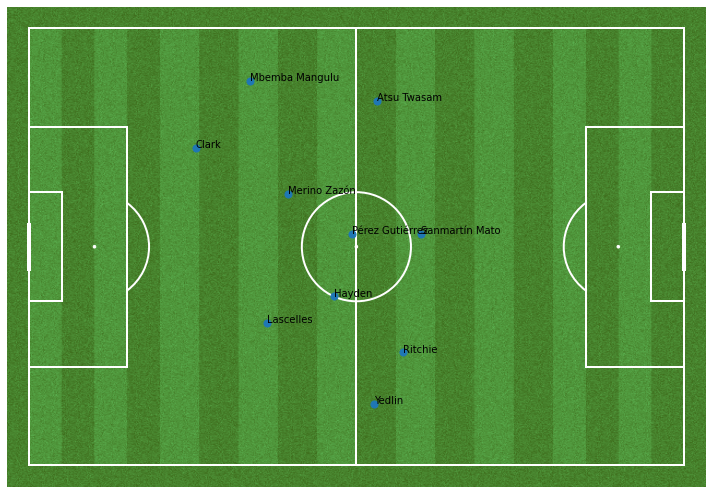

In [25]:
field(tactics,tactics.name)

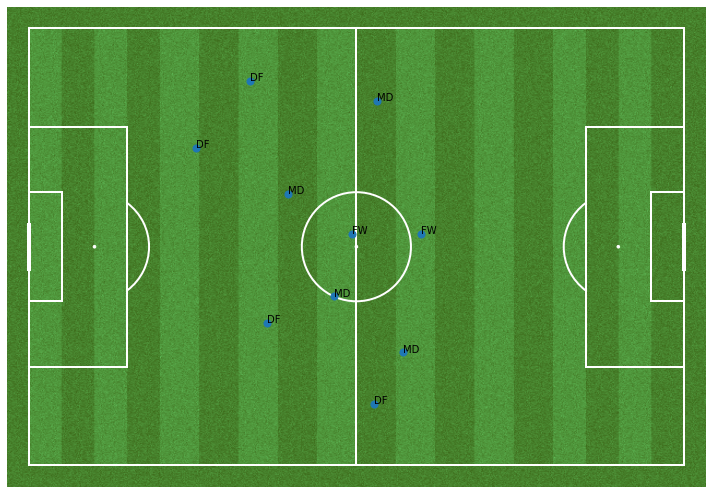

In [26]:
field(tactics,tactics.role)

In [27]:
tott = team_df('Tottenham Hotspur', 4, '1H')

In [28]:
tott_tact = formation(tott)

In [29]:
tott_tact

,x,y,name,role
0,67.837500,56.125000,Sissoko,MD
1,39.101887,60.045283,Alderweireld,DF
2,89.261538,44.676923,Kane,FW
3,68.488889,45.037037,Dier,MD
4,76.110000,33.700000,Dannemann Eriksen,MD
5,82.472727,47.527273,Alli,MD
6,34.302439,36.760976,Sánchez Mina,DF
7,54.690000,73.120000,Trippier,DF
8,48.736364,23.545455,Vertonghen,DF
9,77.742857,11.733333,Davies,DF


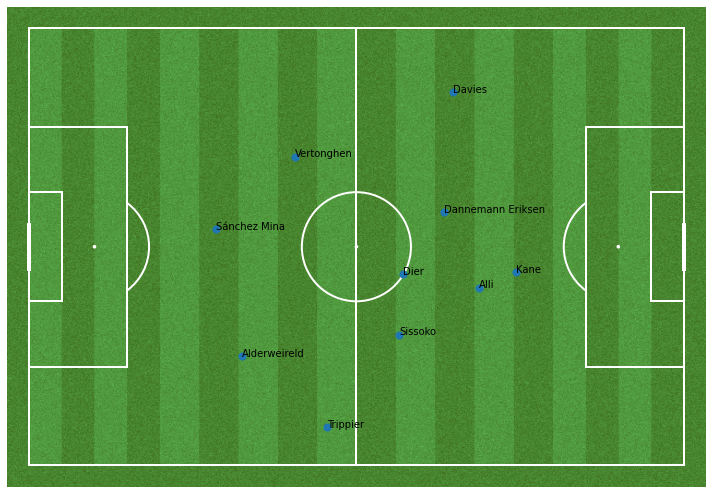

In [30]:
field(tott_tact,tott_tact.name)

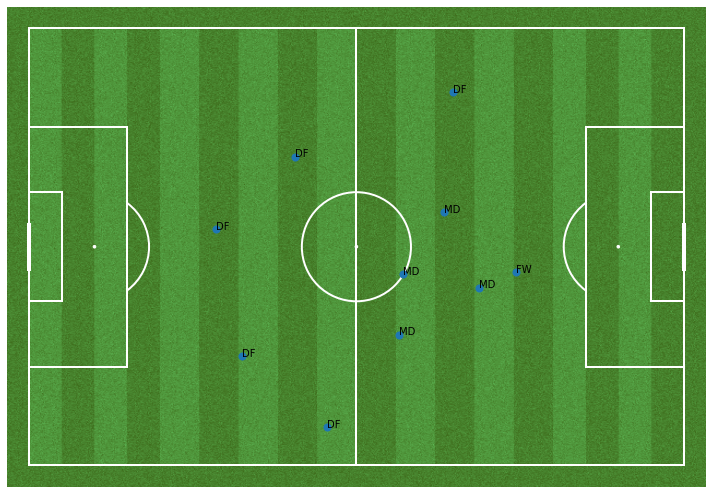

In [31]:
field(tott_tact,tott_tact.role)

When looking at the lineup from this game we can see that they ran a 3-5-1-1 with two defenders playing on the outside positions of the midfield 5. This means our visualization pretty well mirrors the formation used.

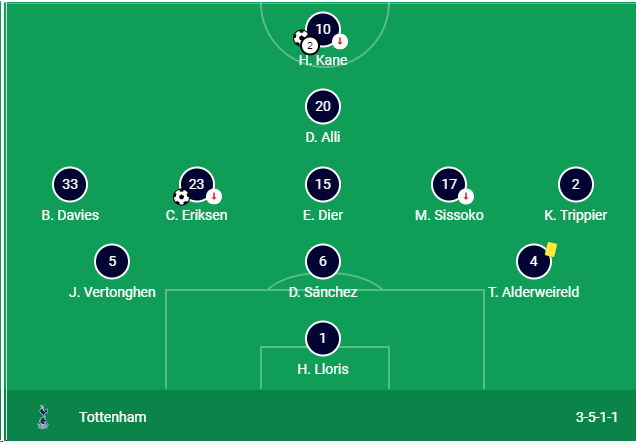
Retrieved from: https://www.google.com/search?q=everton+tottenham+9+September+2017&rlz=1C1CHBF_enUS891US892&oq=everton+tottenham+9+September+2017&aqs=chrome..69i57j33i160.4598j0j15&sourceid=chrome&ie=UTF-8#sie=m;/g/11f4qbqn9t;2;/m/02_tc;ln;fp;1;;